In [2]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from scipy.stats import iqr

NOTE: Somehow need to automate threshold selection. One way: increase until you get a line with angle diff > threshold? Can start with a single value. 100 seems to work for most

For now labeling seems to work best for rectangular images (not irregularly shaped) with lines aligned mostly E-W or N-S

In [3]:
# thresh = 100

# Good labels
# ------------------------------------------
# img_id = '18_nir_2015-08-14';  thresh = 100
# img_id = '20_nir_2009-07-23'; thresh = 100
# img_id = '24_nir_2012-07-11'; thresh = 80  #<-- good
# img_id = '45_nir_2015-08-14'; thresh = 110
# img_id = '46_nir_2014-07-10';  thresh = 100
# img_id = '55_nir_2010-08-25';  thresh = 100
img_id = '73_nir_2013-08-11';  thresh = 120
# img_id = '81_nir_2016-08-03';  thresh = 80
# img_id = '93_nir_2015-07-24'; thresh = 90
# img_id = '76_nir_2013-08-11'; thresh = 90
# img_id = '0_nir_2016-09-03'; thresh = 70
# img_id = '8_nir_2016-08-09'; thresh = 80
# img_id = '15_nir_2010-08-14'; thresh = 80
# img_id = '19_nir_2013-07-28'; thresh = 90
# img_id = '35_nir_2011-08-03'; thresh = 90
# img_id = '77_nir_2013-08-11'; thresh = 90

# Not so good labels
# ------------------------------------------
# img_id = '15_nir_2010-08-14'; thresh = 90
# img_id = '16_nir_2016-06-27'; thresh = 90
# img_id = '1_nir_2010-07-26'; thresh = 50
# img_id = '3_nir_2013-08-01'; thresh = 60
# img_id = '23_nir_2015-08-14'; thresh = 80
# img_id = '48_nir_2011-06-27'; thresh = 80
# img_id = '74_nir_2013-08-11'; thresh = 60

# Bad labels
# ------------------------------------------
# img_id = '15_nir_2010-08-14';  thresh = 80 
# img_id = '27_nir_2014-07-10';  thresh = 80 # diagonal lines
# img_id = '31_nir_2012-06-19';  thresh = 90 # needs to be cropped
# img_id = '64_nir_2013-08-11';  thresh = 80# has 3 patterns
# img_id = '4_nir_2011-08-26'; thresh = 60
# img_id = '11_nir_2015-07-18'; thresh = 80
# img_id = '26_nir_2012-07-02'; thresh = 100
# img_id = '65_nir_2013-08-01'; thresh = 100
# img_id = '91_nir_2014-08-12'; thresh = 90
# img_id = '78_nir_2013-08-11'; thresh = 70 # 2 patterns

filein = '../data/fields_nir/' + img_id + '.png'


In [4]:
def plot_lines(lines):
    for line_idx in range(len(lines)):
        line = lines[line_idx][0]
        rho, theta = (line[0],line[1])
        costh = np.cos(theta)
        sinth = np.sin(theta)
        x0 = rho*costh
        y0 = rho*sinth
        c = 500
        x1 = int(x0 - c*sinth)
        y1 = int(y0 + c*costh)
        x2 = int(x0 + c*sinth)
        y2 = int(y0 - c*costh)

        plt.plot([x1,x2],[y1,y2],'y')

In [5]:
# Load raw image, convert to grayscale
img = cv2.imread(filein)
gray_raw = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

## Load raw image, normalize, saturate, denoise

In [6]:
# Normalized
edge = 0
b, t = np.nanpercentile(gray_raw, [edge, 100 - edge])
gray_norm = 255*(gray_raw - b) / (t - b)

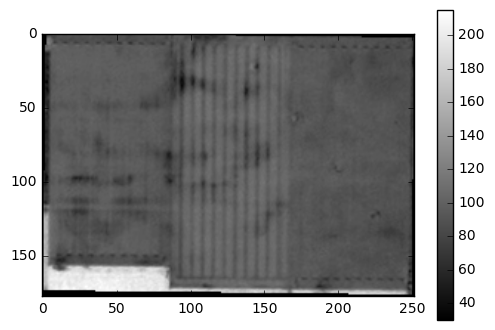

In [7]:
plt.imshow(gray_raw,cmap=matplotlib.cm.get_cmap('gray'))
plt.colorbar()
plt.show()

In [8]:
# For plotting, Replace min with nans
gray_nan = gray_norm.copy()
gray_nan[np.where(gray_nan==np.min(gray_nan))] = np.nan
# gray_nan[np.where(gray_nan==np.min(gray_nan))]

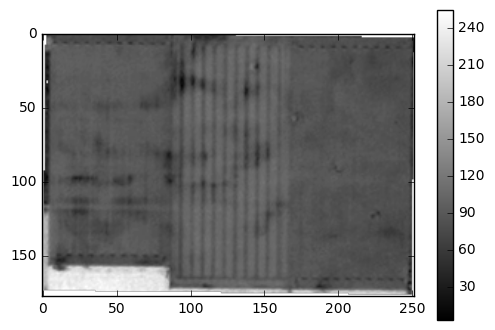

In [9]:
plt.imshow(gray_nan,cmap=matplotlib.cm.get_cmap('gray'))
plt.colorbar()
plt.show()

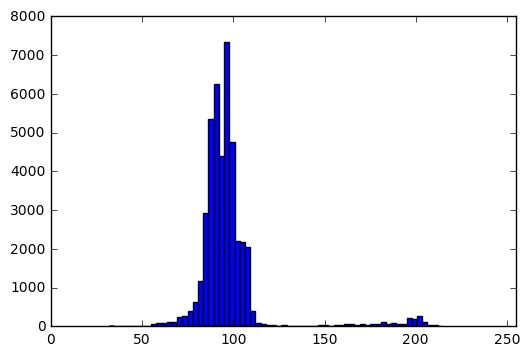

In [10]:
# Plot histogram of values excluding min values

gray_nonzr = np.ravel(gray_raw[np.where(gray_raw!=np.min(gray_raw))])
gray_vec = np.ravel(gray_nonzr)
# gray_vec = gray_vec[~np.isnan(gray_vec)]
plt.hist(gray_vec,64)
plt.xlim(0,255)
plt.show()

In [11]:
# Saturate scale based on percentiles
edge = 5  # percent
b, t = np.percentile(gray_vec, [edge, 100 - edge])

gray_sat = gray_raw.copy()
gray_sat[np.where(gray_sat<b)] = b
gray_sat[np.where(gray_sat>t)] = t

In [12]:
b,t

(81.0, 112.0)

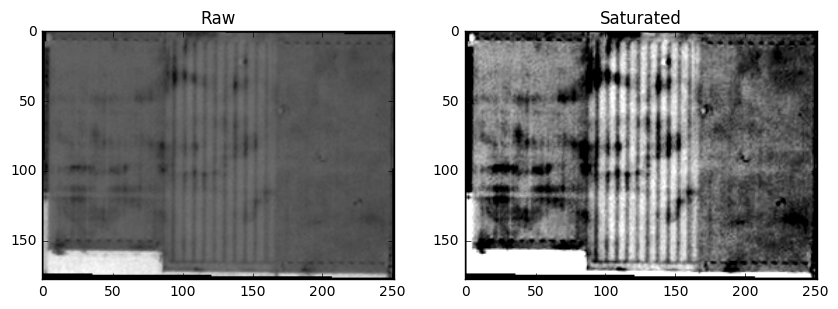

In [13]:
# Plot original and saturated images
plt.figure(figsize=(10, 20))

plt.subplot(1,2,1)
plt.imshow(gray_raw,cmap=matplotlib.cm.get_cmap('gray'))
# plt.colorbar()
plt.title('Raw')

plt.subplot(1,2,2)
plt.imshow(gray_sat,cmap=matplotlib.cm.get_cmap('gray'))
# plt.colorbar()
plt.title('Saturated')

plt.show()

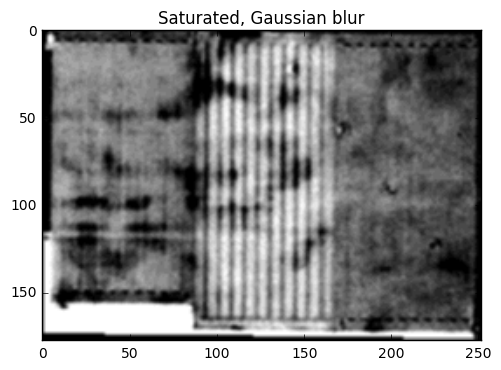

In [14]:
# Gaussian blur?
blur = cv2.GaussianBlur(gray_sat,(3,3),0)
plt.imshow(blur,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Saturated, Gaussian blur')
plt.show()

## Thresholding

In [15]:
# Try some thresholding

# # On raw image
# thr_val_raw = np.median(gray_raw)
# ret,thr_raw = cv2.threshold(gray_raw,thr_val_raw,255,cv2.THRESH_BINARY)

# Binary on saturated image
thr_val_sat = np.median(gray_sat)
ret,thr_sat = cv2.threshold(gray_sat,thr_val_sat,255,cv2.THRESH_BINARY)

# Binary On saturated + Gaussian blur
thr_val_blur = np.median(blur)
ret,thr_blur = cv2.threshold(blur,thr_val_blur,255,cv2.THRESH_BINARY)

# Adaptive on saturated image
thr_ad = cv2.adaptiveThreshold(gray_sat,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,0)

# Adaptive on saturated + Gaussian blur
thr_ad_blur = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,0)


# ret,thr = cv2.threshold(gray,0,255,cv2.THRESH_OTSU)


In [16]:
# Plot thresholded image
# plt.figure(figsize=(10, 10))

# plt.subplot(2,2,1)
# plt.imshow(thr_sat,cmap=matplotlib.cm.get_cmap('gray'))
# plt.title('Binary thresholding')

# plt.subplot(2,2,2)
# plt.imshow(thr_blur,cmap=matplotlib.cm.get_cmap('gray'))
# plt.title('Binary thresholding after Gaussian blur')

# plt.subplot(2,2,3)
# plt.imshow(thr_ad,cmap=matplotlib.cm.get_cmap('gray'))
# plt.title('Adaptive Thresholding')

# plt.subplot(2,2,4)
# plt.imshow(thr_ad_blur,cmap=matplotlib.cm.get_cmap('gray'))
# plt.title('Adapt. thresh. after Gaussian blur')

# plt.show()

In [17]:
# Adaptive thresholding for different block sizes

# thr_ad_blur_1 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,3,0)
# thr_ad_blur_2 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,0)
# thr_ad_blur_3 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,7,0)
# thr_ad_blur_4 = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,0)

# plt.figure(figsize=(10, 10))

# plt.subplot(2,2,1)
# plt.imshow(thr_ad_blur_1,cmap=matplotlib.cm.get_cmap('gray'))
# plt.title('block size = 3')

# plt.subplot(2,2,2)
# plt.imshow(thr_ad_blur_2,cmap=matplotlib.cm.get_cmap('gray'))
# plt.title('block size = 5')

# plt.subplot(2,2,3)
# plt.imshow(thr_ad_blur_3,cmap=matplotlib.cm.get_cmap('gray'))
# plt.title('block size = 7')

# plt.subplot(2,2,4)
# plt.imshow(thr_ad_blur_4,cmap=matplotlib.cm.get_cmap('gray'))
# plt.title('block size = 11')

# plt.show()


## Edge detection

In [18]:
# Edge detection on binary image (adaptive threshold after Gaussian blur)

# edges_sat = cv2.Canny(gray_sat,50,150,apertureSize = 3)
# edges_thr = cv2.Canny(thr_sat,50,150,apertureSize = 3)

edges_ad_thr = cv2.Canny(thr_ad_blur,100,150,apertureSize = 5)



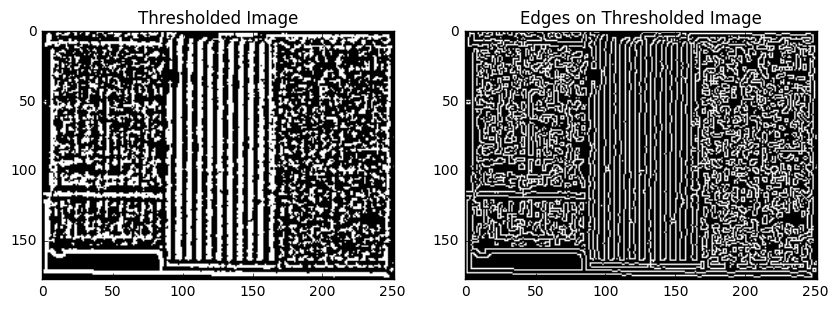

In [19]:
# Plot detected eges on original and saturated images
plt.figure(figsize=(10, 20))

# plt.subplot(1,2,1)
# plt.imshow(edges_sat,cmap=matplotlib.cm.get_cmap('gray'))
# plt.title('Edges on Saturated Image')

# plt.subplot(1,2,2)
# plt.imshow(edges_thr,cmap=matplotlib.cm.get_cmap('gray'))
# plt.title('Edges on Thresholded Image')

plt.subplot(1,2,1)
plt.imshow(thr_ad_blur,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Thresholded Image')

plt.subplot(1,2,2)
plt.imshow(edges_ad_thr,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Edges on Thresholded Image')

plt.show()

## Line detection

For ROUGH direction detection:
If dominant line direction is NS-EW, then set 2nd threshold to 0.5 to avoid picking diagonal lines

But, if the image has diagonal lines, need to increase 2nd threshold to 1

In [20]:
# Line detection on binary image itself
lines_thr = cv2.HoughLines(thr_ad_blur,0.7,1*np.pi/180,thresh)
len(lines_thr)

36

In [21]:
# Nlines = []
# thresholds = range(70,100,10)
# for threshold in thresholds:
#     lines_thr = cv2.HoughLines(thr_ad_blur,0.5,1*np.pi/180,threshold)
#     Nlines.append(len(lines_thr))
# Nlines = np.array(Nlines)
# thresholds = np.array(thresholds)

# plt.plot(thresholds,Nlines,'.-')
# plt.show()

# Line detection on edges 
# lines_edges = cv2.HoughLines(edges_ad_thr,0.5,1*np.pi/180,60)
# len(lines_edges)

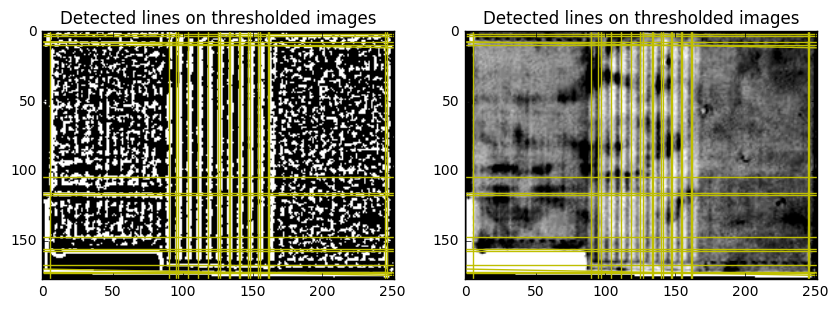

In [22]:
plt.figure(figsize=(10, 10))

plt.subplot(121)
plt.imshow(thr_ad_blur,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Detected lines on thresholded images')
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()
plot_lines(lines_thr)
plt.gca().set_ylim(ylim)
plt.gca().set_xlim(xlim)

# plt.subplot(222)
# plt.imshow(edges_ad_thr,cmap=matplotlib.cm.get_cmap('gray'))
# plt.title('Detected lines on edges')
# ylim = plt.gca().get_ylim()
# xlim = plt.gca().get_xlim()
# plot_lines(lines_edges)
# plt.gca().set_ylim(ylim)
plt.gca().set_xlim(xlim)

plt.subplot(122)
plt.imshow(gray_sat,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Detected lines on thresholded images')
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()
plot_lines(lines_thr)
plt.gca().set_ylim(ylim)
plt.gca().set_xlim(xlim)

# plt.subplot(224)
# plt.imshow(gray_sat,cmap=matplotlib.cm.get_cmap('gray'))
# plt.title('Detected lines on edges')
# ylim = plt.gca().get_ylim()
# xlim = plt.gca().get_xlim()
# plot_lines(lines_edges)
# plt.gca().set_ylim(ylim)
# plt.gca().set_xlim(xlim)


plt.show()


## Line segment detection

In [23]:
# Probabilistic Hough transform (detects line segments)

minLineLength = 20
maxLineGap = 1
lines_pr = cv2.HoughLinesP(thr_ad_blur,1,np.pi/180,10,minLineLength,maxLineGap)
# lines_pr = cv2.HoughLinesP(edges_ad_thr,1,np.pi/180,50,minLineLength,maxLineGap)
len(lines_pr)

2426

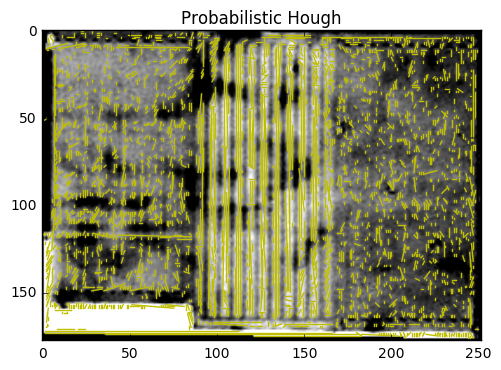

In [24]:
plt.imshow(gray_sat,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Probabilistic Hough')
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()
# plot_lines(lines_pr)
for line_idx in range(len(lines_pr)):
    line = lines_pr[line_idx][0]
    plt.plot([line[0],line[2]],[line[1],line[3]],'y')
plt.gca().set_ylim(ylim)
plt.gca().set_xlim(xlim)
plt.show()

In [25]:
thetas_pr = []
lengths_pr = []
for line in lines_pr.squeeze():
    x1 = line[0]
    y1 = line[1]
    x2 = line[2]
    y2 = line[3]
    theta = np.arctan2(y2-y1,x2-x1)*180/ np.pi
    thetas_pr.append(theta)
    length = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    lengths_pr.append(length)
thetas_pr = np.array(thetas_pr)
lengths_pr = np.array(lengths_pr)


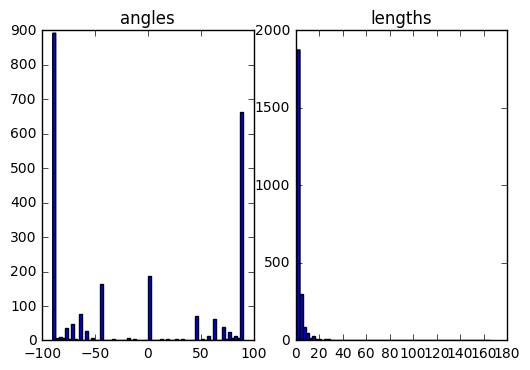

In [26]:
plt.figure
plt.subplot(121)
plt.hist(thetas_pr,64)
plt.title('angles')

plt.subplot(122)
plt.hist(lengths_pr,64)
plt.title('lengths')

plt.show()


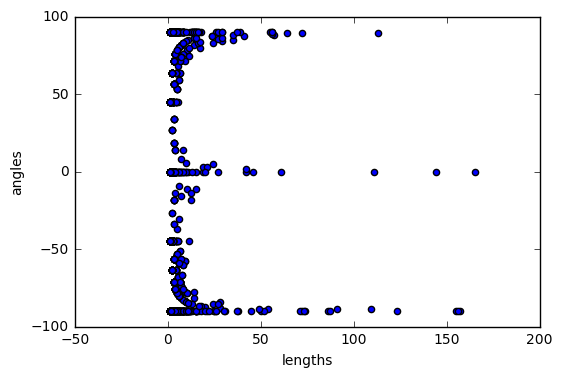

In [27]:
# This could be used to pick dominant angles given a threshold on line length
plt.scatter(lengths_pr,thetas_pr)
plt.xlabel('lengths')
plt.ylabel('angles')
plt.show()


## Feature Extraction and Clustering

In [28]:
# Plots lines according to their labels. Assumes 2 classes
def plot_lines_lab(lines,labels):
    for line_idx in range(len(lines)):
        line = lines[line_idx][0]
        rho, theta = (line[0],line[1])
        costh = np.cos(theta)
        sinth = np.sin(theta)
        x0 = rho*costh
        y0 = rho*sinth
        c = 500
        x1 = int(x0 - c*sinth)
        y1 = int(y0 + c*costh)
        x2 = int(x0 + c*sinth)
        y2 = int(y0 - c*costh)

        color = 'g' if labels[line_idx] else 'r'
        plt.plot([x1,x2],[y1,y2],color)

In [29]:
# Function to return centroids of detected lines
def get_centroids(lines):
    XC = np.array([])
    YC = np.array([]);
    
    for line_idx in range(len(lines)):
        line = lines[line_idx][0]
        rho, theta = (line[0],line[1])
        costh = np.cos(theta)
        sinth = np.sin(theta)
        x0 = rho*costh
        y0 = rho*sinth
        c = 500
        x1 = int(x0 - c*sinth)
        y1 = int(y0 + c*costh)
        x2 = int(x0 + c*sinth)
        y2 = int(y0 - c*costh)

        xc, yc = (0.5*(x1+x2),0.5*(y1+y2))

        XC = np.append(XC,xc)
        YC = np.append(YC,yc)

    return XC,YC


In [30]:
# Feature 1: angle 
angles = lines_thr.squeeze()[:,1]#*180./np.pi

In [31]:
# Feature 2: distance to closest centroid
XC, YC = get_centroids(lines_thr)
centroids = np.array([XC, YC]).T
distances = pdist(centroids,'euclidean')
D = squareform(distances)
D[D==0] = np.nan

dist_clos = np.array([])
for line in range(len(lines_thr)):
    dist_clos = np.append(dist_clos,np.nanmin(D[line,:]))

In [32]:
# Feature 3: number of lines with similar angle
angle_res = 10*np.pi/180 # angle resolution in degrees

Nsim = np.empty(len(angles))
for i in range(len(angles)):
    angle = angles[i]
    diffs = np.array([])
    for j in range(len(angles)):
        diffs = np.append(diffs,np.abs(angle - angles[j]))

    Nsim[i] = len(diffs[diffs<=angle_res])

In [33]:
Nsim

array([ 15.,  15.,  15.,  21.,  21.,  21.,  21.,  21.,  21.,  21.,  21.,
        21.,  21.,  15.,  21.,  21.,  21.,  21.,  15.,  21.,  15.,  15.,
        21.,  21.,  15.,  15.,  15.,  21.,  15.,  21.,  15.,  15.,  21.,
        21.,  15.,  15.])

In [34]:
features = np.array([angles,np.log10(dist_clos),Nsim]).T

In [35]:
# K-means clustering on the two features angles assuming 2 clusters (true,false)

kmeans = KMeans(n_clusters=2).fit(features)
labels_cl = kmeans.labels_

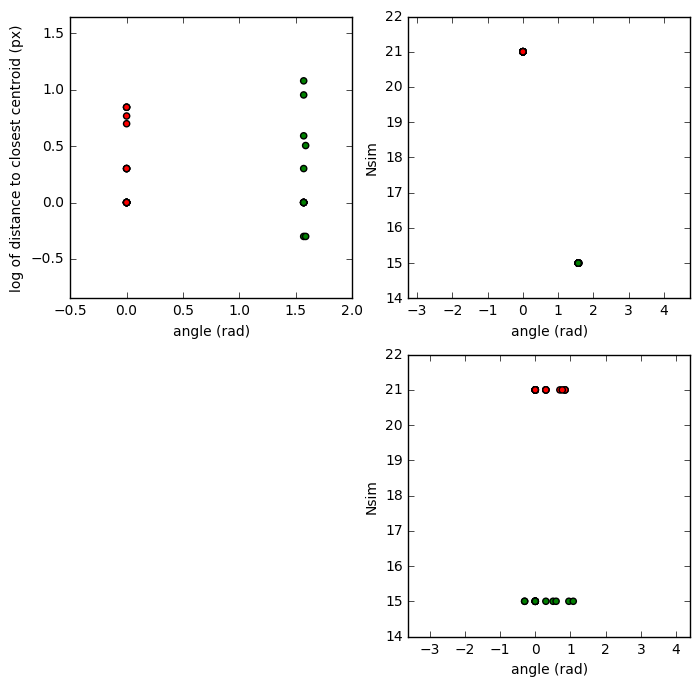

In [36]:
colors = ['g' if label else 'r' for label in labels_cl]

plt.figure(figsize=(8,8))

plt.subplot(221)
plt.scatter(angles,np.log10(dist_clos),c=colors)
plt.xlabel('angle (rad)')
plt.ylabel('log of distance to closest centroid (px)')
plt.axis('equal')

plt.subplot(222)
plt.scatter(angles,Nsim,c=colors)
plt.xlabel('angle (rad)')
plt.ylabel('Nsim')
plt.axis('equal')

plt.subplot(224)
plt.scatter(np.log10(dist_clos),Nsim,c=colors)
plt.xlabel('angle (rad)')
plt.ylabel('Nsim')
plt.axis('equal')


plt.show()

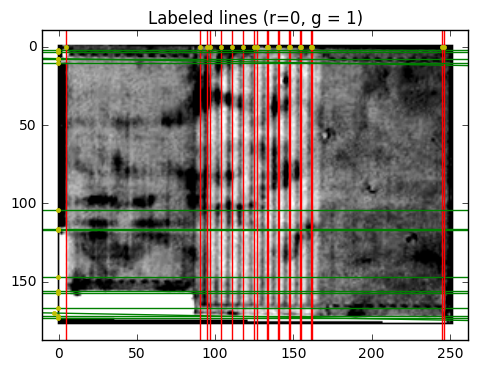

In [37]:
plt.imshow(gray_sat,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Labeled lines (r=0, g = 1)')
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()
plot_lines_lab(lines_thr,labels_cl)
plt.gca().set_ylim(ylim[0]+10,ylim[1]-10)
plt.gca().set_xlim(xlim[0]-10,xlim[1]+10)
plt.plot(XC,YC,'.y')

plt.show()

## Labeling

In [38]:
np.abs(np.diff(Nsim))

array([ 0.,  0.,  6.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  6.,
        6.,  0.,  0.,  0.,  6.,  6.,  6.,  0.,  6.,  0.,  6.,  0.,  0.,
        6.,  6.,  6.,  6.,  0.,  6.,  0.,  6.,  0.])

In [39]:
# Decide to label according to clusters or lump all lines in the same label
# if all lines have similar angles, then they belong to the same group, which is assumed to be in the true class
lump = not(bool(np.sum(np.abs(np.diff(Nsim)))))
lump

False

In [40]:
if lump:
    # spread in spacing (for now std, should change to IQR)
    spread_true  = iqr(dist_clos)

    # number of lines in group as a fraction of total lines in image
    frac_true  = 1.
    
    obs_vec_true  = (spread_true,  frac_true,  1)

else:
    # Set true class (0 (red) or 1 (green))
    true_class = 1

    # Find lines belonging to each class
    ix_true  = np.where(labels_cl==true_class)
    ix_false = np.where(labels_cl!=true_class)

    # Features for group of lines in true class

    # spread in spacing (for now std, should change to IQR)
    spread_true  = iqr(dist_clos[ix_true])
    spread_false = iqr(dist_clos[ix_false])

    # number of lines in group as a fraction of total lines in image
    frac_true  = len(ix_true[0])/float(len(ix_true[0])+len(ix_false[0]))
    frac_false = 1 - frac_true
    
    obs_vec_true  = (spread_true,  frac_true,  1)
    obs_vec_false = (spread_false, frac_false, 0)


In [41]:
# Don't output either class if it has only one member
Ntrue = len(labels_cl[labels_cl==true_class])
Nfalse = len(labels_cl[labels_cl==int(not(true_class))])
Ntrue, Nfalse

(15, 21)

In [42]:
print obs_vec_true
if not(lump):
    print obs_vec_false

(1.6007810593582121, 0.4166666666666667, 1)
(1.0, 0.5833333333333333, 0)


In [43]:
# TODO: Print vectors to file if there are more than one members in the cluster